In [1]:
# === BASIC EMA CROSSOVER STRATEGY VS BUY & HOLD ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ticker = "MSFT"

In [3]:
# Parameters
ticker = "TSLA"


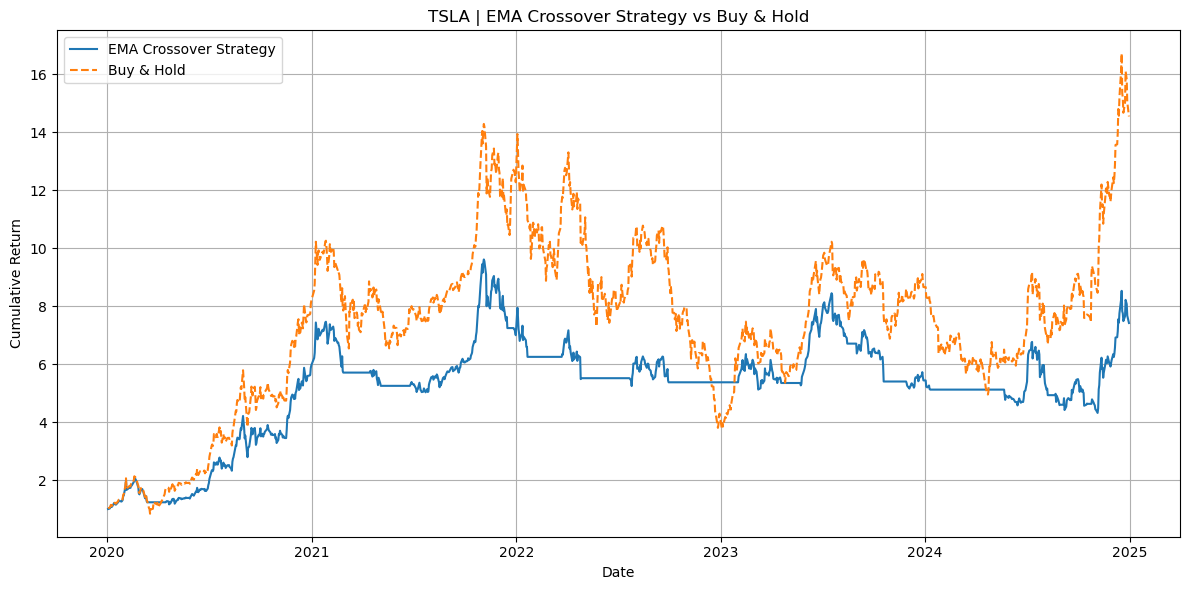


 TSLA | EMA Crossover Strategy Metrics:
Total Return (%): 642.18
Annualized Volatility (%): 50.96
Sharpe Ratio: 1.04
Max Drawdown (%): -55.10

 TSLA | Buy & Hold Metrics:
Total Return (%): 1355.20
Annualized Volatility (%): 67.19
Sharpe Ratio: 1.13
Max Drawdown (%): -73.63


In [4]:
# === PARAMETERS ===
start_date = '2020-01-01'
end_date = '2024-12-31'

# === 1. Download historical data ===
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
data = data[['Close']].copy()

# === 2. Calculate EMAs ===
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# === 3. Generate Trading Signals ===
data['Signal'] = 0
data.loc[data['EMA_10'] > data['EMA_50'], 'Signal'] = 1
data['Position'] = data['Signal'].shift(1)

# === 4. Compute Strategy Returns ===
data['Daily Return'] = data['Close'].pct_change()
data['Strategy Return'] = data['Position'] * data['Daily Return']
data.dropna(inplace=True)

# === 5. Cumulative Returns ===
cumulative_strategy = (1 + data['Strategy Return']).cumprod()
cumulative_buyhold = (1 + data['Daily Return']).cumprod()

# === 6. Plot Performance ===
plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='EMA Crossover Strategy')
plt.plot(cumulative_buyhold, label='Buy & Hold', linestyle='--')
plt.title(f'{ticker} | EMA Crossover Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{ticker.lower()}_ema_strategy.png", dpi=300, bbox_inches='tight')
plt.show()

# === 7. Portfolio-Level Metrics ===
def compute_metrics(returns, risk_free_rate=0.0):
    cumulative_return = (1 + returns).prod() - 1
    sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)
    rolling_max = (1 + returns).cumprod().cummax()
    drawdown = (1 + returns).cumprod() / rolling_max - 1
    max_drawdown = drawdown.min()
    return {
        "Total Return (%)": cumulative_return * 100,
        "Annualized Volatility (%)": returns.std() * np.sqrt(252) * 100,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown * 100
    }

strategy_metrics = compute_metrics(data['Strategy Return'])
buyhold_metrics = compute_metrics(data['Daily Return'])

print(f"\n {ticker} | EMA Crossover Strategy Metrics:")
for k, v in strategy_metrics.items():
    print(f"{k}: {v:.2f}")

print(f"\n {ticker} | Buy & Hold Metrics:")
for k, v in buyhold_metrics.items():
    print(f"{k}: {v:.2f}")

import json

with open(f"Outputs/{ticker}_00_metrics.json", "w") as f:
    json.dump(buyhold_metrics, f, indent=2)

with open(f"Outputs/{ticker}_01_metrics.json", "w") as f:
    json.dump(strategy_metrics, f, indent=2)